In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlutilpy as sqlutil
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table


from dustmaps.sfd import SFDQuery
from dustmaps.config import config
import os
from matplotlib.colors import LogNorm


In [ ]:
# ================================================================
# Full-sky GALEX × DECaLS (1″) → Gaia DR2/DR3 → SDSS DR9
# ================================================================


# ----------------------------------------------------------------
# 1.  All-sky cross-match
# ----------------------------------------------------------------
query = """
WITH xmatch AS (
    SELECT
      g.objid    AS galex_objid,
      d.objid    AS decals_objid,
      q3c_dist(g.ra, g.dec, d.ra, d.dec)*3600   AS sep_arcsec,

      /* GALEX UV */
      g.ra   AS galex_ra,   g.dec  AS galex_dec,
      g.nuv_mag, g.nuv_magerr,
      g.fuv_mag, g.fuv_magerr,
      g.nuv_class_star, g.fuv_class_star,
      g.e_bv,

      /* DECaLS photometry */
      d.ra   AS decals_ra,  d.dec   AS decals_dec,
      d.flux_g, d.flux_r, d.flux_z,
      d.flux_ivar_g, d.flux_ivar_r, d.flux_ivar_z,
      d.type     AS decals_type,
      d.shape_r, d.shape_e1, d.shape_e2, d.sersic,

      /* Gaia DR2 link */
      d.ref_id   AS gaia2_id
    FROM galexgr6.aisprimary AS g
    JOIN decals_dr9.main      AS d
      ON q3c_join(g.ra, g.dec, d.ra, d.dec, 1.0/3600.0)
)

SELECT
       xm.*,

       /* DECaLS flux → mags */
       CASE WHEN flux_g>0 THEN 22.5 - 2.5*log(flux_g) END       AS g_mag,
       CASE WHEN flux_r>0 THEN 22.5 - 2.5*log(flux_r) END       AS r_mag,
       CASE WHEN flux_z>0 THEN 22.5 - 2.5*log(flux_z) END       AS z_mag,
       CASE WHEN flux_g>0 AND flux_ivar_g>0
            THEN 2.5/(ln(10)*flux_g*sqrt(flux_ivar_g)) END    AS g_magerr,
       CASE WHEN flux_r>0 AND flux_ivar_r>0
            THEN 2.5/(ln(10)*flux_r*sqrt(flux_ivar_r)) END    AS r_magerr,
       CASE WHEN flux_z>0 AND flux_ivar_z>0
            THEN 2.5/(ln(10)*flux_z*sqrt(flux_ivar_z)) END    AS z_magerr,

       /* Gaia DR2 */
       g2.ra               AS gaia2_ra,
       g2.dec              AS gaia2_dec,
       g2.phot_g_mean_mag  AS gaia2_g,
       g2.phot_bp_mean_mag AS gaia2_bp,
       g2.phot_rp_mean_mag AS gaia2_rp,
       g2.parallax         AS gaia2_parallax,
       g2.pmra             AS gaia2_pmra,
       g2.pmdec            AS gaia2_pmdec,

       /* nearest Gaia EDR3 */
       g3.source_id            AS gaia3_id,
       g3.ra                   AS gaia3_ra,
       g3.dec                  AS gaia3_dec,
       g3.phot_g_mean_mag      AS phot_g_mean_mag,
       g3.phot_bp_mean_mag     AS phot_bp_mean_mag,
       g3.phot_rp_mean_mag     AS phot_rp_mean_mag,
       g3.parallax             AS parallax,
       g3.pmra                 AS pmra,
       g3.pmdec                AS pmdec,
       g3.pmra_error           AS pmra_error,
       g3.pmdec_error          AS pmdec_error,
       g3.parallax_over_error  AS parallax_over_error,
       n.angular_distance      AS dr2_dr3_sep_arcsec,
       n.magnitude_difference  AS dr2_dr3_dmag,

       /* SDSS DR9 phototag */
       s.objid            AS sdss_objid,
       s.ra               AS sdss_ra,
       s.dec              AS sdss_dec,
       s.psfmag_u         AS sdss_u,
       s.psfmag_g         AS sdss_g,
       s.psfmag_r         AS sdss_r,
       s.psfmag_i         AS sdss_i,
       s.psfmag_z         AS sdss_z,
       s.psfmagerr_u      AS sdss_u_err,
       s.psfmagerr_g      AS sdss_g_err,
       s.psfmagerr_r      AS sdss_r_err,
       s.psfmagerr_i      AS sdss_i_err,
       s.psfmagerr_z      AS sdss_z_err,
       sdnb.angular_distance AS gaia3_sdss_sep_arcsec

FROM   xmatch AS xm
LEFT   JOIN gaia_dr2.gaia_source           AS g2
       ON g2.source_id = xm.gaia2_id
LEFT   JOIN LATERAL (
       SELECT dr3_source_id, angular_distance, magnitude_difference
       FROM   gaia_edr3.dr2_neighbourhood
       WHERE  dr2_source_id = g2.source_id
       ORDER  BY angular_distance, magnitude_difference
       LIMIT  1
) n  ON TRUE
LEFT   JOIN gaia_edr3.gaia_source           AS g3
       ON g3.source_id = n.dr3_source_id
LEFT   JOIN gaia_edr3_aux.sdssdr13bestneighbour AS sdnb
       ON sdnb.source_id = g3.source_id
LEFT   JOIN LATERAL (
       SELECT objid, ra, dec,
              psfmag_u, psfmag_g, psfmag_r, psfmag_i, psfmag_z,
              psfmagerr_u, psfmagerr_g, psfmagerr_r,
              psfmagerr_i, psfmagerr_z
       FROM   sdssdr9.phototag
       WHERE  objid = sdnb.original_ext_source_id
) s ON TRUE
"""

# ----------------------------------------------------------------
# 2.  Execute and load into pandas
# ----------------------------------------------------------------
df = pd.DataFrame(su.get(query, db='wsdb', asDict=True))

print(f"Total GALEX–DECaLS pairs returned: {len(df)}")

# keep only the closest DECaLS match per GALEX object
df = df.sort_values("sep_arcsec").drop_duplicates("galex_objid")
print(f"After dropping duplicates: {len(df)}")

# compute proper-motion S/N
df["pm_total_snr"] = np.hypot(df["pmra"], df["pmdec"]) / \
                     np.hypot(df["pmra_error"], df["pmdec_error"])

print("Column names (5 per line):")
for i in range(0, len(df.columns), 5):
    print(", ".join(df.columns[i:i+5]))

In [34]:
# GALEX × DECaLS rectangle → Gaia DR2/DR3 → SDSS DR9 with |b| > bmin via fk52galb()

ra_min, ra_max   = 0, 360.0    # degrees
dec_min, dec_max = -90.0, 90.0
bmin             = 30.0         # Galactic latitude cut in degrees

print(f"RA ∈ [{ra_min}, {ra_max}], Dec ∈ [{dec_min}, {dec_max}], |b| > {bmin}°")

query = """
WITH params AS (
    SELECT %(ramn)s::float8 AS ra_min,
           %(ramx)s::float8 AS ra_max,
           %(demn)s::float8 AS dec_min,
           %(demx)s::float8 AS dec_max
),
xmatch AS (
    SELECT g.objid    AS galex_objid,
           d.objid    AS decals_objid,
           q3c_dist(g.ra,g.dec,d.ra,d.dec)*3600    AS sep_arcsec,

           g.ra        AS galex_ra,
           g.dec       AS galex_dec,
           g.nuv_mag, g.nuv_magerr,
           g.fuv_mag, g.fuv_magerr,
           g.nuv_class_star, g.fuv_class_star, g.e_bv,

           d.ra        AS decals_ra,
           d.dec       AS decals_dec,
           d.flux_g, d.flux_r, d.flux_z,
           d.flux_ivar_g, d.flux_ivar_r, d.flux_ivar_z,
           d.type      AS decals_type,
           d.shape_r, d.shape_e1, d.shape_e2, d.sersic,

           d.ref_id    AS gaia2_id
    FROM params p
    JOIN galexgr6.aisprimary g
      ON g.ra  BETWEEN p.ra_min AND p.ra_max
     AND g.dec BETWEEN p.dec_min AND p.dec_max
    JOIN decals_dr9.main d
      ON q3c_join(g.ra,g.dec,d.ra,d.dec,1.0/3600.0)
),
final AS (
    SELECT xm.*,

           /* DECaLS flux→mag */
           CASE WHEN flux_g>0 THEN 22.5-2.5*log(flux_g) END AS g_mag,
           CASE WHEN flux_r>0 THEN 22.5-2.5*log(flux_r) END AS r_mag,
           CASE WHEN flux_z>0 THEN 22.5-2.5*log(flux_z) END AS z_mag,
           CASE WHEN flux_g>0 AND flux_ivar_g>0
                THEN 2.5/(ln(10)*flux_g*sqrt(flux_ivar_g)) END AS g_magerr,
           CASE WHEN flux_r>0 AND flux_ivar_r>0
                THEN 2.5/(ln(10)*flux_r*sqrt(flux_ivar_r)) END AS r_magerr,
           CASE WHEN flux_z>0 AND flux_ivar_z>0
                THEN 2.5/(ln(10)*flux_z*sqrt(flux_ivar_z)) END AS z_magerr,

           /* Gaia DR2 – only high-lat sources pass */
           g2.ra               AS gaia2_ra,
           g2.dec              AS gaia2_dec,
           g2.phot_g_mean_mag  AS gaia2_g,
           g2.phot_bp_mean_mag AS gaia2_bp,
           g2.phot_rp_mean_mag AS gaia2_rp,
           g2.parallax         AS gaia2_parallax,
           g2.pmra             AS gaia2_pmra,
           g2.pmdec            AS gaia2_pmdec,

           /* nearest Gaia DR3 via lateral lookup */
           g3.source_id            AS gaia3_id,
           g3.ra                   AS gaia3_ra,
           g3.dec                  AS gaia3_dec,
           g3.phot_g_mean_mag      AS phot_g_mean_mag,
           g3.phot_bp_mean_mag     AS phot_bp_mean_mag,
           g3.phot_rp_mean_mag     AS phot_rp_mean_mag,
           g3.parallax             AS parallax,
           g3.pmra                 AS pmra,
           g3.pmdec                AS pmdec,
           g3.pmra_error           AS pmra_error,
           g3.pmdec_error          AS pmdec_error,
           g3.parallax_over_error  AS parallax_over_error,
           g3.ruwe                 AS ruwe,
           g3.astrometric_excess_noise     AS astrometric_excess_noise,
           g3.astrometric_excess_noise_sig AS astrometric_excess_noise_sig,
           n.angular_distance      AS dr2_dr3_sep_arcsec,
           n.magnitude_difference  AS dr2_dr3_dmag,

           /* SDSS DR9 phototag via on-demand lookup */
           s.objid             AS sdss_objid,
           s.ra                AS sdss_ra,
           s.dec               AS sdss_dec,
           s.psfmag_u          AS sdss_u,
           s.psfmag_g          AS sdss_g,
           s.psfmag_r          AS sdss_r,
           s.psfmag_i          AS sdss_i,
           s.psfmag_z          AS sdss_z,
           s.psfmagerr_u       AS sdss_u_err,
           s.psfmagerr_g       AS sdss_g_err,
           s.psfmagerr_r       AS sdss_r_err,
           s.psfmagerr_i       AS sdss_i_err,
           s.psfmagerr_z       AS sdss_z_err,
           sdnb.angular_distance AS gaia3_sdss_sep_arcsec
    FROM xmatch xm

    /* Gaia DR2 key + high-latitude cut via fk52galb() */
    LEFT JOIN gaia_dr2.gaia_source g2
      ON g2.source_id = xm.gaia2_id
     AND abs(fk52galb(g2.ra, g2.dec)) > %(bmin)s

    /* nearest DR3 neighbour */
    LEFT JOIN LATERAL (
        SELECT dr3_source_id, angular_distance, magnitude_difference
        FROM gaia_edr3.dr2_neighbourhood
        WHERE dr2_source_id = g2.source_id
        ORDER BY angular_distance, magnitude_difference
        LIMIT 1
    ) n ON TRUE

    LEFT JOIN gaia_edr3.gaia_source g3
      ON g3.source_id = n.dr3_source_id

    /* SDSS mapping */
    LEFT JOIN gaia_edr3_aux.sdssdr13bestneighbour sdnb
      ON sdnb.source_id = g3.source_id

    /* phototag lookup by index */
    LEFT JOIN LATERAL (
        SELECT objid, ra, dec,
               psfmag_u, psfmag_g, psfmag_r, psfmag_i, psfmag_z,
               psfmagerr_u, psfmagerr_g, psfmagerr_r,
               psfmagerr_i, psfmagerr_z
        FROM sdssdr9.phototag
        WHERE objid = sdnb.original_ext_source_id
    ) s ON TRUE
)

SELECT * FROM final
ORDER BY sep_arcsec;
"""

params = {
    "ramn":   ra_min,
    "ramx":   ra_max,
    "demn":   dec_min,
    "demx":   dec_max,
    "bmin":   bmin
}

df = pd.DataFrame(sqlutil.get(query, params, db='wsdb', asDict=True))
print(f"Patch returned {len(df)} pairs.")

RA ∈ [0, 360.0], Dec ∈ [-90.0, 90.0], |b| > 30.0°
Patch returned 20564516 pairs.


In [35]:
output_fits = os.path.expanduser("~/data/lrd_search/all_sky_data.fits")
Table.from_pandas(df).write(output_fits, overwrite=True)
print(f"Saved DataFrame to FITS: {output_fits}")

Saved DataFrame to FITS: /Users/vasilybelokurov/data/lrd_search/all_sky_data.fits


In [41]:
df.to_parquet(
    "~/data/lrd_search/all_sky_data.parquet",
    engine="fastparquet",
    compression="snappy",
)

In [27]:
# keep closest DECaLS per GALEX
df = df.sort_values("sep_arcsec").drop_duplicates("galex_objid")
print(f"After dropping duplicates: {len(df)}")

# Compute Gaia proper motion SNR: sqrt(pmra^2 + pmdec^2) / sqrt(pmra_error^2 + pmdec_error^2)
df["pm_total_snr"] = (
    np.sqrt(df["pmra"]**2 + df["pmdec"]**2) /
    np.sqrt(df["pmra_error"]**2 + df["pmdec_error"]**2)
)

After dropping duplicates: 645282


In [28]:
# --------------------------------------------------------------
# Extinction correction  (GALEX + SDSS/DECaLS u,g,r,z + Gaia)
# --------------------------------------------------------------


# -------------------------------------------------------------- #
# 0.  Query SFD E(B–V)
# -------------------------------------------------------------- #
sfd    = SFDQuery()
coords = SkyCoord(ra=df['decals_ra'].values,
                  dec=df['decals_dec'].values, unit='deg')
df['ebv'] = sfd(coords)

# -------------------------------------------------------------- #
# 1.  Aλ / E(B–V) coefficients
#    GALEX/SDSS: Schlafly & Finkbeiner 2011
#    Gaia      : Casagrande & VandenBerg 2018
# -------------------------------------------------------------- #
ext_coeff = {
    'fuv'    : 8.31,
    'nuv'    : 8.74,
    'u'      : 4.239,  
    'g'      : 3.303,
    'r'      : 2.285,
    'z'      : 1.263,
    'gaia_g' : 2.742,
    'gaia_bp': 3.172,
    'gaia_rp': 1.634,
}

# -------------------------------------------------------------- #
# 2.  Locate SDSS-u column, standardise name
# -------------------------------------------------------------- #
u_lookup = ['sdss_u', 'u_mag', 'psfMag_u']
u_obs_col = next((c for c in u_lookup if c in df.columns), None)
if u_obs_col is None:
    raise KeyError(f'Could not find u-band column (looked for {u_lookup})')
df.rename(columns={u_obs_col: 'u_mag'}, inplace=True)

# -------------------------------------------------------------- #
# 3.  Deredden GALEX + SDSS/DECaLS  (now incl. u)
# -------------------------------------------------------------- #
for band in ['fuv', 'nuv', 'u', 'g', 'r', 'z']:
    df[f'A_{band}']        = ext_coeff[band] * df['ebv']
    df[f'{band}_mag_corr'] = df[f'{band}_mag'] - df[f'A_{band}']

# -------------------------------------------------------------- #
# 4.  Locate Gaia columns, standardise names (unchanged)
# -------------------------------------------------------------- #
gaia_lookup = {
    'gaia_bp_mag': ['gaia_bp_mag','phot_bp_mean_mag','bp_mag','bp'],
    'gaia_g_mag' : ['gaia_g_mag' ,'phot_g_mean_mag' ,'g_mag' ,'g'],
    'gaia_rp_mag': ['gaia_rp_mag','phot_rp_mean_mag','rp_mag','rp'],
}
for std_name, aliases in gaia_lookup.items():
    found = next((c for c in aliases if c in df.columns), None)
    if found is None:
        raise KeyError(f'Could not find Gaia column for {std_name} '
                       f'(looked for {aliases})')
    df.rename(columns={found: std_name}, inplace=True)

# -------------------------------------------------------------- #
# 5.  Deredden Gaia passbands
# -------------------------------------------------------------- #
for gaia_pref in ['gaia_g', 'gaia_bp', 'gaia_rp']:
    df[f'A_{gaia_pref}']        = ext_coeff[gaia_pref] * df['ebv']
    df[f'{gaia_pref}_mag_corr'] = df[f'{gaia_pref}_mag'] - df[f'A_{gaia_pref}']

# -------------------------------------------------------------- #
# 6.  Set dereddened mags as the default working columns
# -------------------------------------------------------------- #
# for band in ['fuv','nuv','u','g','r','z','gaia_g','gaia_bp','gaia_rp']:
#     df[f'{band}_mag'] = df[f'{band}_mag_corr']

# -------------------------------------------------------------- #
# 7.  Sanity report
# -------------------------------------------------------------- #
print("Extinction correction applied")
print(f"E(B–V): {df['ebv'].min():.4f} – {df['ebv'].max():.4f} "
      f"(mean {df['ebv'].mean():.4f})")
for k in ['u','g','r','z','gaia_g','gaia_bp','gaia_rp']:
    print(f"A_{k}: {df[f'A_{k}'].min():.3f} – {df[f'A_{k}'].max():.3f}")
print("\nDereddened columns gaia_[bp|g|rp]_mag_corr and u_mag_corr "
      "now exist for downstream colour diagnostics.")

Extinction correction applied
E(B–V): 0.0025 – 0.2953 (mean 0.0312)
A_u: 0.010 – 1.252
A_g: 0.008 – 0.975
A_r: 0.006 – 0.675
A_z: 0.003 – 0.373
A_gaia_g: 0.007 – 0.810
A_gaia_bp: 0.008 – 0.937
A_gaia_rp: 0.004 – 0.483

Dereddened columns gaia_[bp|g|rp]_mag_corr and u_mag_corr now exist for downstream colour diagnostics.


In [29]:
objid = 6382632234073984504

# Select the row(s) in df where galex_objid matches the target objid
df_target = df[df['galex_objid'] == objid]


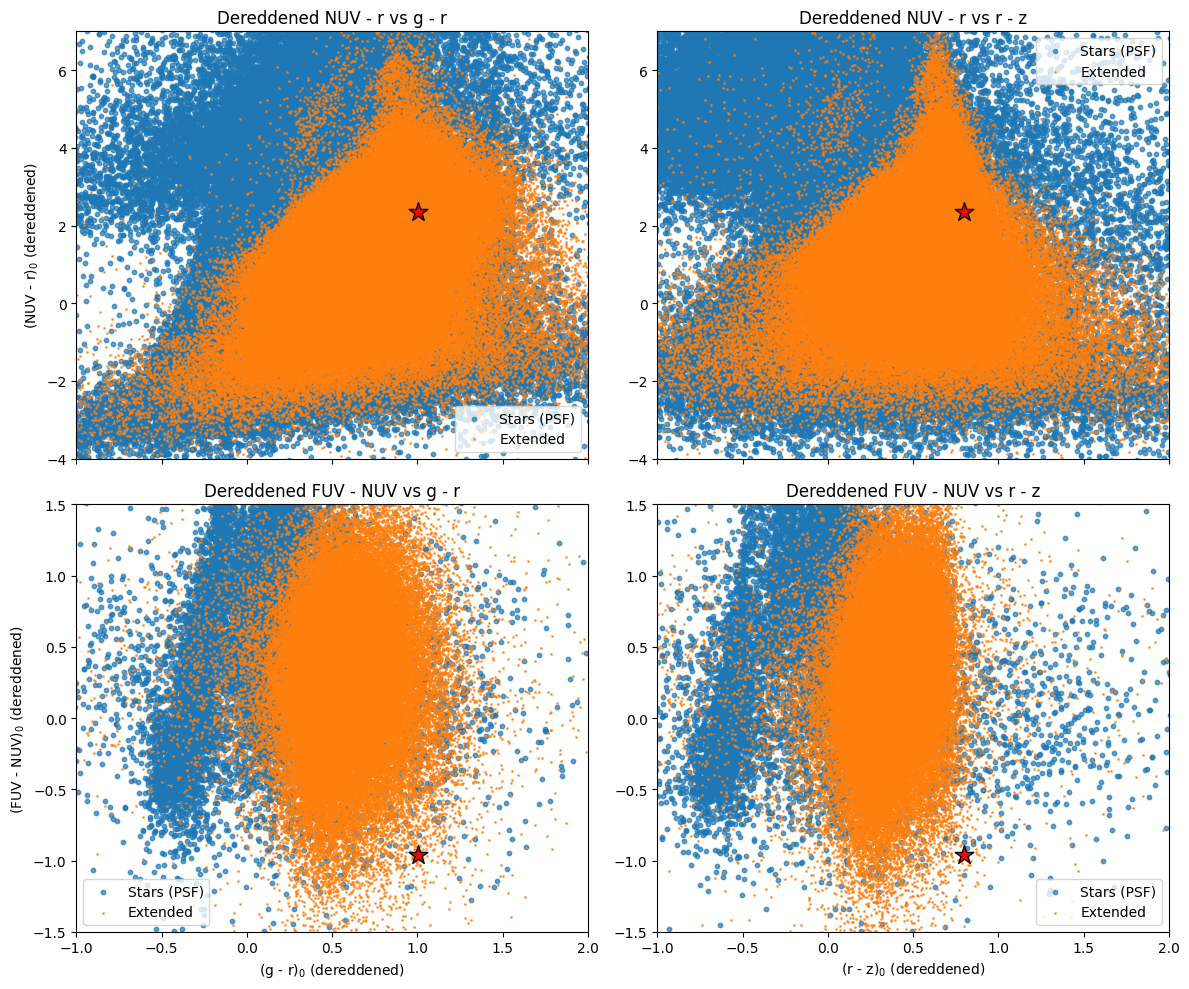

Object type statistics:
  Stars (PSF): 263315
  Extended: 381967
  Total: 645282
  Target type: PSF

Target dereddened colors:
  (g - r)₀ = 1.004
  (r - z)₀ = 0.796
  (NUV - r)₀ = 2.360
  (FUV - NUV)₀ = -0.960


In [30]:
# SETUP
nuvr_range = [-4, 7]
fuvnuv_range = [-1.5, 1.5]
gr_range = [-1, 2]
rz_range = [-1, 2]

# Symbol size parameters
s_star = 10
s_extended = 1

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex='col')

# Calculate colors using dereddened magnitudes
nuv_r = df['nuv_mag_corr'] - df['r_mag_corr']
fuv_nuv = df['fuv_mag_corr'] - df['nuv_mag_corr']
g_r = df['g_mag_corr'] - df['r_mag_corr']
r_z = df['r_mag_corr'] - df['z_mag_corr']

# Separate stars and extended objects
stars = df['decals_type'] == 'PSF'
extended = df['decals_type'] != 'PSF'

# TOP ROW: NUV-r on y-axis
# Panel 1: NUV-r vs g-r (dereddened)
axes[0,0].scatter(g_r[stars], nuv_r[stars], s=s_star, alpha=0.7, color='tab:blue', label='Stars (PSF)')
axes[0,0].scatter(g_r[extended], nuv_r[extended], s=s_extended, alpha=0.7, color='tab:orange', label='Extended')
axes[0,0].set_ylabel('(NUV - r)$_0$ (dereddened)')
axes[0,0].set_title('Dereddened NUV - r vs g - r')
axes[0,0].legend()

# Overplot the target as a red star (using dereddened mags)
axes[0,0].scatter(
    df_target['g_mag_corr'].values - df_target['r_mag_corr'].values,
    df_target['nuv_mag_corr'].values - df_target['r_mag_corr'].values,
    color='red', marker='*', s=200, edgecolor='black', label='Target'
)

# Panel 2: NUV-r vs r-z (dereddened)
axes[0,1].scatter(r_z[stars], nuv_r[stars], s=s_star, alpha=0.7, color='tab:blue', label='Stars (PSF)')
axes[0,1].scatter(r_z[extended], nuv_r[extended], s=s_extended, alpha=0.7, color='tab:orange', label='Extended')
axes[0,1].set_title('Dereddened NUV - r vs r - z')
axes[0,1].legend()

# Overplot the target as a red star (using dereddened mags)
axes[0,1].scatter(
    df_target['r_mag_corr'].values - df_target['z_mag_corr'].values,
    df_target['nuv_mag_corr'].values - df_target['r_mag_corr'].values,
    color='red', marker='*', s=200, edgecolor='black', label='Target'
)

# BOTTOM ROW: FUV-NUV on y-axis
# Panel 3: FUV-NUV vs g-r (dereddened)
axes[1,0].scatter(g_r[stars], fuv_nuv[stars], s=s_star, alpha=0.7, color='tab:blue', label='Stars (PSF)')
axes[1,0].scatter(g_r[extended], fuv_nuv[extended], s=s_extended, alpha=0.7, color='tab:orange', label='Extended')
axes[1,0].set_xlabel('(g - r)$_0$ (dereddened)')
axes[1,0].set_ylabel('(FUV - NUV)$_0$ (dereddened)')
axes[1,0].set_title('Dereddened FUV - NUV vs g - r')
axes[1,0].legend()

# Overplot the target as a red star (using dereddened mags)
axes[1,0].scatter(
    df_target['g_mag_corr'].values - df_target['r_mag_corr'].values,
    df_target['fuv_mag_corr'].values - df_target['nuv_mag_corr'].values,
    color='red', marker='*', s=200, edgecolor='black', label='Target'
)

# Panel 4: FUV-NUV vs r-z (dereddened)
axes[1,1].scatter(r_z[stars], fuv_nuv[stars], s=s_star, alpha=0.7, color='tab:blue', label='Stars (PSF)')
axes[1,1].scatter(r_z[extended], fuv_nuv[extended], s=s_extended, alpha=0.7, color='tab:orange', label='Extended')
axes[1,1].set_xlabel('(r - z)$_0$ (dereddened)')
axes[1,1].set_title('Dereddened FUV - NUV vs r - z')
axes[1,1].legend()

# Overplot the target as a red star (using dereddened mags)
axes[1,1].scatter(
    df_target['r_mag_corr'].values - df_target['z_mag_corr'].values,
    df_target['fuv_mag_corr'].values - df_target['nuv_mag_corr'].values,
    color='red', marker='*', s=200, edgecolor='black', label='Target'
)

# Set axis limits
axes[0,0].set_xlim(gr_range)
axes[0,0].set_ylim(nuvr_range)
axes[0,1].set_xlim(rz_range)
axes[0,1].set_ylim(nuvr_range)
axes[1,0].set_xlim(gr_range)
axes[1,0].set_ylim(fuvnuv_range)
axes[1,1].set_xlim(rz_range)
axes[1,1].set_ylim(fuvnuv_range)

plt.tight_layout()
plt.show()

# Print object type statistics
print(f"Object type statistics:")
print(f"  Stars (PSF): {stars.sum()}")
print(f"  Extended: {extended.sum()}")
print(f"  Total: {len(df)}")
print(f"  Target type: {df_target['decals_type'].values[0] if len(df_target) > 0 else 'N/A'}")

# Print target dereddened colors
if len(df_target) > 0:
    target_gr = df_target['g_mag_corr'].values[0] - df_target['r_mag_corr'].values[0]
    target_rz = df_target['r_mag_corr'].values[0] - df_target['z_mag_corr'].values[0]
    target_nuvr = df_target['nuv_mag_corr'].values[0] - df_target['r_mag_corr'].values[0]
    target_fuvnuv = df_target['fuv_mag_corr'].values[0] - df_target['nuv_mag_corr'].values[0]
    print(f"\nTarget dereddened colors:")
    print(f"  (g - r)₀ = {target_gr:.3f}")
    print(f"  (r - z)₀ = {target_rz:.3f}")
    print(f"  (NUV - r)₀ = {target_nuvr:.3f}")
    print(f"  (FUV - NUV)₀ = {target_fuvnuv:.3f}")

Number of LRD candidates selected: 2
Figure saved as: /Users/vasilybelokurov/Work/Code/lrd_search/lrd_colour_colour_density.png


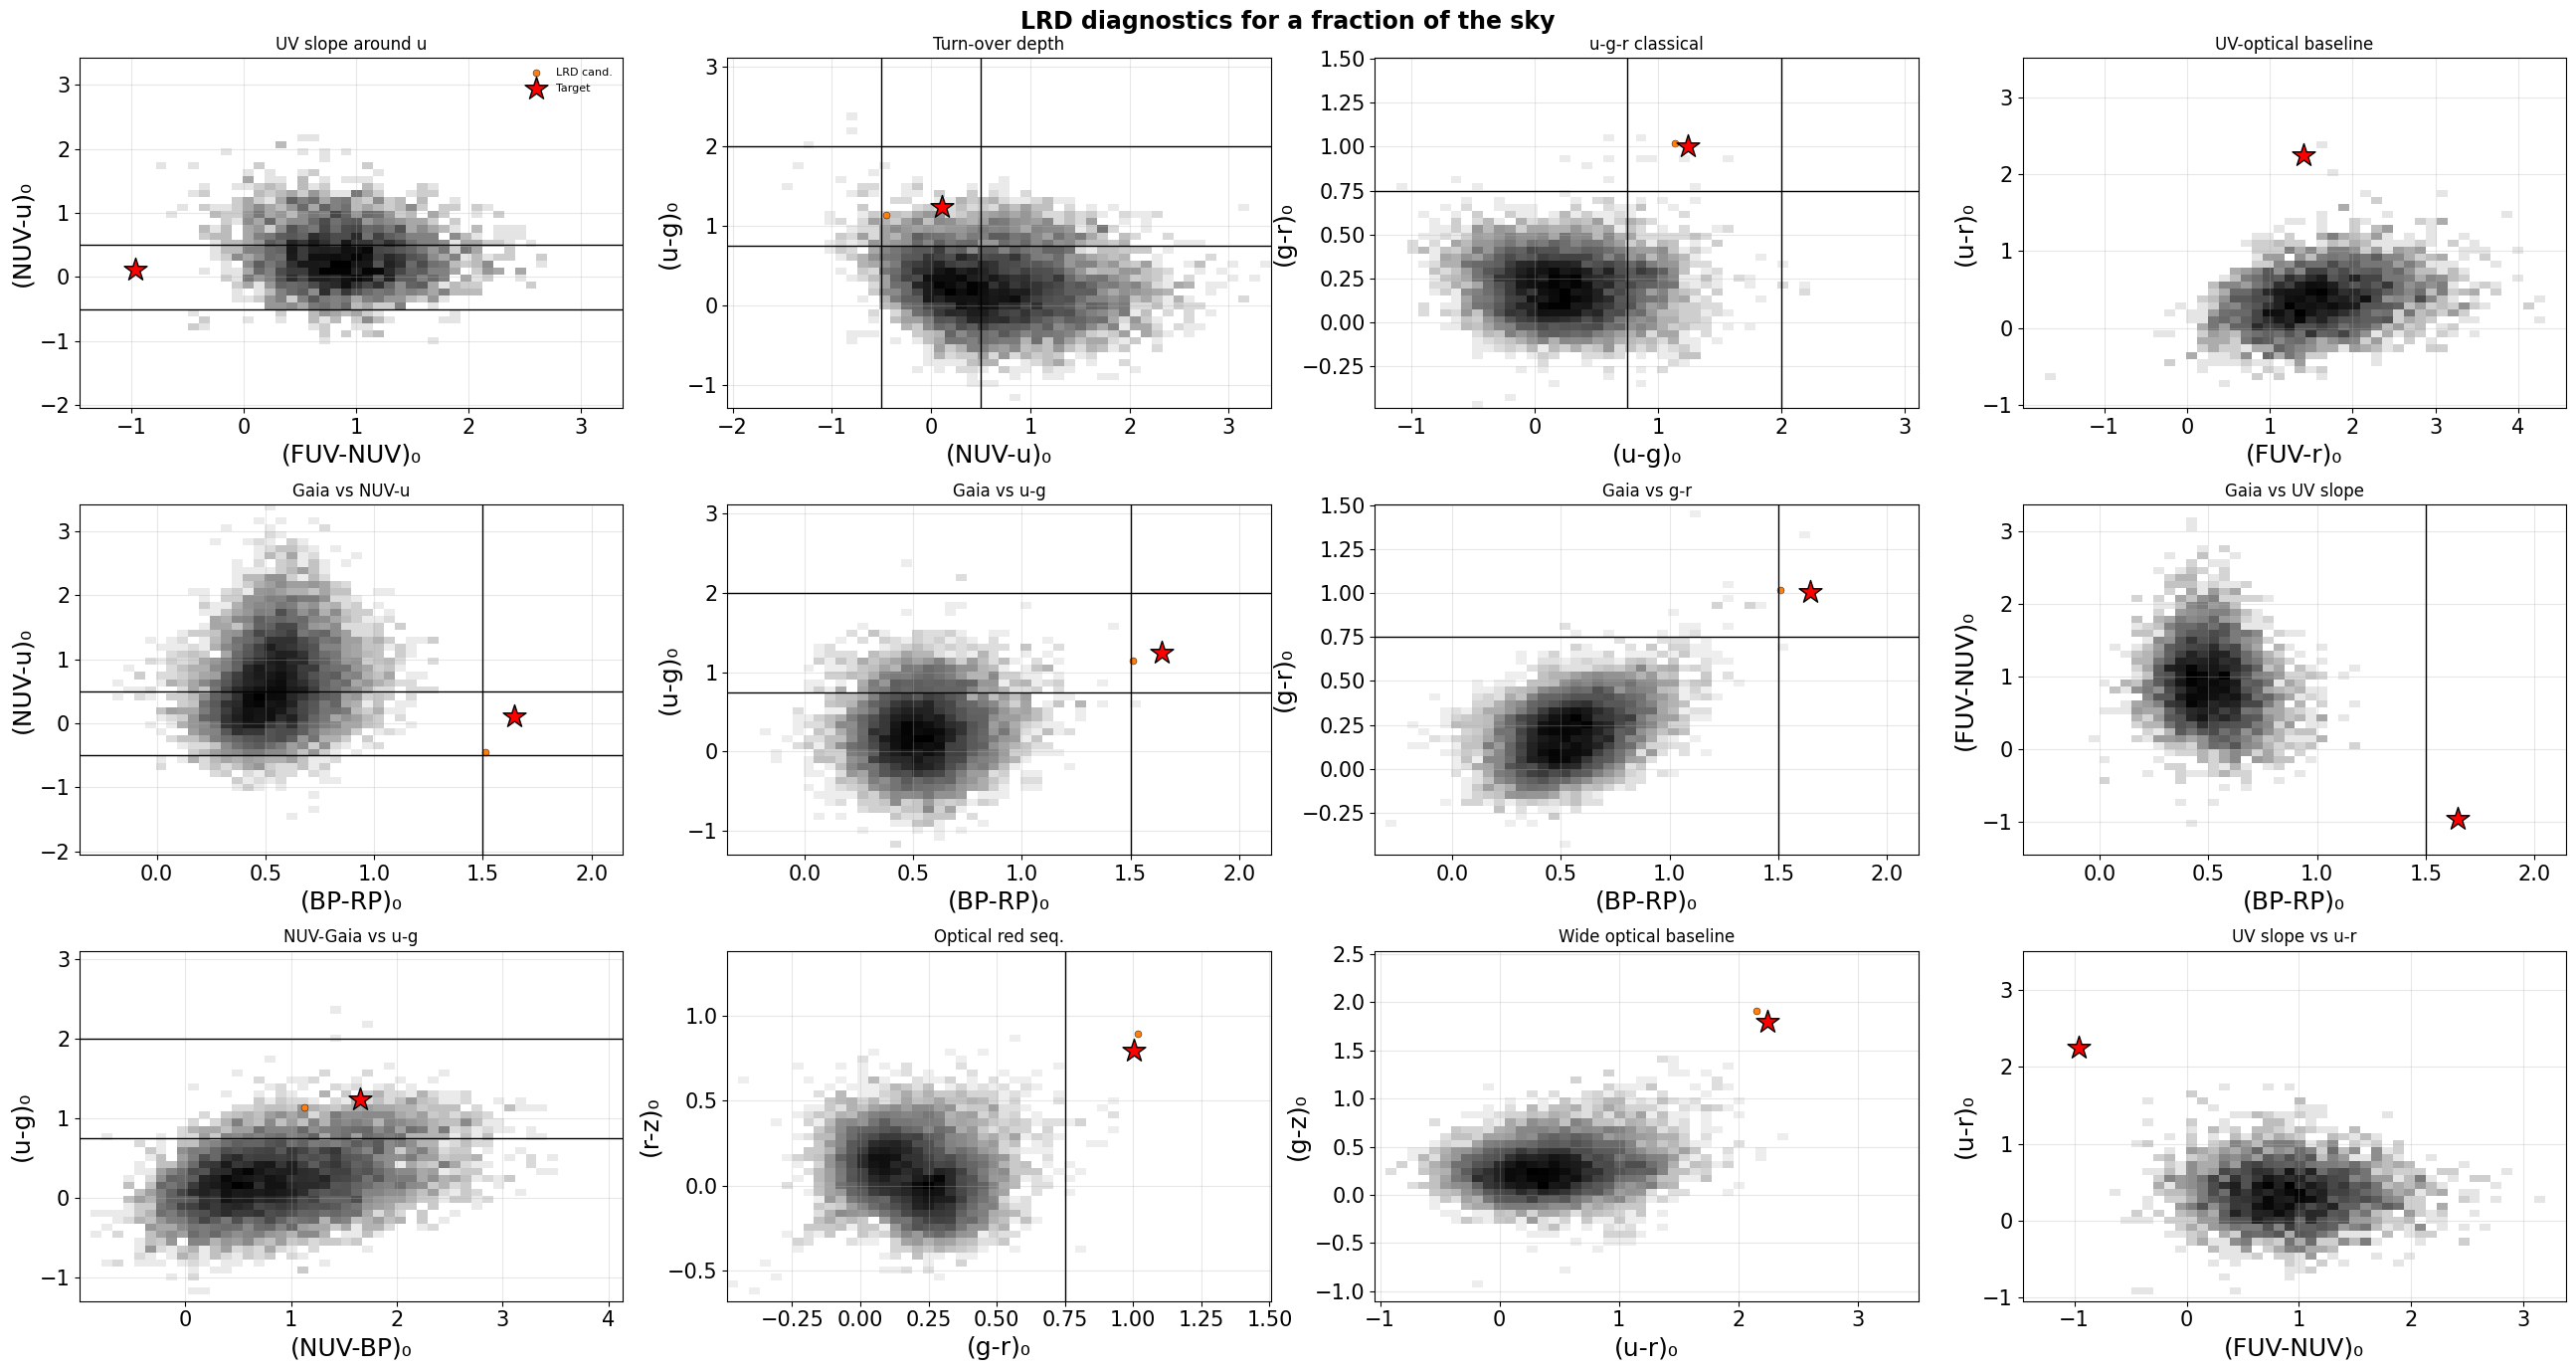

In [32]:
# ================================================================
# LRD colour–colour diagnostics   (GALEX + SDSS u,g,r,z + Gaia)
# ================================================================
import numpy as np, os, matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plot_flag  = 'density'          #  'scatter'  or  'density'
bins_2d    = 50                 #  histogram resolution

# ----------------------------------------------------------------
# Candidate-selection criteria   {colour_key: (min, max)}
# (None ⇒ no limit on that side)
# ----------------------------------------------------------------
sel_criteria = {
    'bp_rp': (1.5, None),       # BP-RP  > 1.5
    'g_r'  : (0.75, None),      # g-r   > 0.75
    'nuv_u': (-0.5, 0.5),       # −0.5 < NUV-u < 0.5
    'u_g'  : (0.75, 2),       # 0.75 < u-g < 2
}

# ================================================================
# Helper: axis limits padded to include the target
# ================================================================
def get_axis_limits(arr, target, pad=0.5, lo=0.1, hi=99.9, vmax=10):
    good = arr[np.isfinite(arr) & (np.abs(arr) < vmax)]
    amin, amax = (-1, 1) if good.size == 0 else np.nanpercentile(good, [lo, hi])
    return min(amin, target - pad), max(amax, target + pad)

# ----------------------------------------------------------------
# 0.  Sanity check for required dereddened columns
# ----------------------------------------------------------------
needed = ['fuv_mag_corr','nuv_mag_corr','u_mag_corr','g_mag_corr',
          'r_mag_corr','z_mag_corr',
          'gaia_bp_mag_corr','gaia_g_mag_corr','gaia_rp_mag_corr']
missing = [c for c in needed if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing} – run extinction cell first")

# ----------------------------------------------------------------
# 1.  Working subset: star-like extra-galactic
# ----------------------------------------------------------------
pm_snr_max, parallax_snr_max = 2, 2
df_use = df.loc[(df['pm_total_snr']        < pm_snr_max) &
                (df['parallax_over_error'] < parallax_snr_max) &
                (df['decals_type']         == 'PSF')].copy()

# ----------------------------------------------------------------
# 2.  Colour definitions   key → (bright_band, faint_band)
# ----------------------------------------------------------------
pairs = {
    'fuv_nuv': ('fuv_mag_corr',  'nuv_mag_corr'),
    'nuv_u'  : ('nuv_mag_corr',  'u_mag_corr'),
    'u_g'    : ('u_mag_corr',    'g_mag_corr'),
    'u_r'    : ('u_mag_corr',    'r_mag_corr'),
    'fuv_r'  : ('fuv_mag_corr',  'r_mag_corr'),
    'g_r'    : ('g_mag_corr',    'r_mag_corr'),
    'r_z'    : ('r_mag_corr',    'z_mag_corr'),
    'g_z'    : ('g_mag_corr',    'z_mag_corr'),
    'bp_rp'  : ('gaia_bp_mag_corr','gaia_rp_mag_corr'),
    'nuv_bp' : ('nuv_mag_corr',  'gaia_bp_mag_corr'),
}

# Colours for catalogue & (optional) target
c  = {k: df_use[p1] - df_use[p2] for k, (p1, p2) in pairs.items()}
tc = None
if len(df_target):
    trow = df.loc[df_target.index[0]]
    tc   = {k: trow[p1] - trow[p2] for k, (p1, p2) in pairs.items()}

# ----------------------------------------------------------------
# 3.  Candidate mask from sel_criteria
# ----------------------------------------------------------------
mask = np.ones(len(df_use), dtype=bool)
for col_key, (vmin, vmax) in sel_criteria.items():
    if vmin is not None:
        mask &= (c[col_key] >= vmin)
    if vmax is not None:
        mask &= (c[col_key] <= vmax)
lrd_can = mask
print(f"Number of LRD candidates selected: {lrd_can.sum()}")

# ----------------------------------------------------------------
# 4.  Plane specification
# ----------------------------------------------------------------
planes = [
    (0,0,'fuv_nuv','nuv_u' , '(FUV-NUV)₀','(NUV-u)₀', 'UV slope around u'),
    (0,1,'nuv_u' , 'u_g'   , '(NUV-u)₀' , '(u-g)₀'  , 'Turn-over depth'),
    (0,2,'u_g'   , 'g_r'   , '(u-g)₀'   , '(g-r)₀'  , 'u-g-r classical'),
    (0,3,'fuv_r' , 'u_r'   , '(FUV-r)₀' , '(u-r)₀'  , 'UV-optical baseline'),
    (1,0,'bp_rp' , 'nuv_u' , '(BP-RP)₀' , '(NUV-u)₀', 'Gaia vs NUV-u'),
    (1,1,'bp_rp' , 'u_g'   , '(BP-RP)₀' , '(u-g)₀'  , 'Gaia vs u-g'),
    (1,2,'bp_rp' , 'g_r'   , '(BP-RP)₀' , '(g-r)₀'  , 'Gaia vs g-r'),
    (1,3,'bp_rp' , 'fuv_nuv','(BP-RP)₀','(FUV-NUV)₀','Gaia vs UV slope'),
    (2,0,'nuv_bp','u_g'    , '(NUV-BP)₀','(u-g)₀'  , 'NUV-Gaia vs u-g'),
    (2,1,'g_r'   , 'r_z'   , '(g-r)₀'   , '(r-z)₀'  , 'Optical red seq.'),
    (2,2,'u_r'   , 'g_z'   , '(u-r)₀'   , '(g-z)₀'  , 'Wide optical baseline'),
    (2,3,'fuv_nuv','u_r'   , '(FUV-NUV)₀','(u-r)₀'  , 'UV slope vs u-r'),
]

# ----------------------------------------------------------------
# 5.  Plotting
# ----------------------------------------------------------------
fig, ax = plt.subplots(3, 4, figsize=(26, 14))


fig.suptitle(f'LRD diagnostics for a fraction of the sky', fontsize=17, fontweight='bold')

stars, galaxies = df_use['decals_type']=='PSF', df_use['decals_type']!='PSF'

for row, col, xk, yk, xlab, ylab, title in planes:
    a = ax[row, col]
    x, y = c[xk], c[yk]

    xmin, xmax = get_axis_limits(x, tc[xk] if tc else 0)
    ymin, ymax = get_axis_limits(y, tc[yk] if tc else 0)
    a.set_xlim(xmin, xmax); a.set_ylim(ymin, ymax)
    a.set_xlabel(xlab); a.set_ylabel(ylab); a.set_title(title); a.grid(alpha=0.3)
    a.tick_params(axis='both', labelsize=15)
    a.xaxis.label.set_size(18)
    a.yaxis.label.set_size(18)

    # base visualisation
    if plot_flag == 'scatter':
        a.scatter(x[stars],    y[stars],    s=8, alpha=0.6, color='tab:blue',  label='Stars')
        a.scatter(x[galaxies], y[galaxies], s=3, alpha=0.6, color='tab:gray', label='Galaxies')
    elif plot_flag == 'density':
        mask_xy = np.isfinite(x) & np.isfinite(y)
        hist, _, _ = np.histogram2d(x[mask_xy], y[mask_xy],
                                    bins=bins_2d,
                                    range=[[xmin, xmax], [ymin, ymax]])
        a.imshow(hist.T, origin='lower',
                 extent=[xmin, xmax, ymin, ymax],
                 aspect='auto', cmap='Greys',
                 norm=LogNorm(vmin=1, vmax=hist.max()))
    else:
        raise ValueError("plot_flag must be 'scatter' or 'density'")

    # candidate overlay
    a.scatter(x[lrd_can], y[lrd_can], s=25, marker='o',
              color='tab:orange', edgecolor='k', linewidths=0.3,
              label='LRD cand.' if (row==0 and col==0) else None)

    # target overlay
    if tc:
        a.scatter(tc[xk], tc[yk], s=300, marker='*',
                  color='red', edgecolor='k', zorder=10,
                  label='Target' if (row==0 and col==0) else None)

    # draw selection cut lines where relevant
    for col_key, (vmin, vmax) in sel_criteria.items():
        if xk == col_key:
            if vmin is not None: a.axvline(vmin, color='k', lw=1)
            if vmax is not None: a.axvline(vmax, color='k', lw=1)
        if yk == col_key:
            if vmin is not None: a.axhline(vmin, color='k', lw=1)
            if vmax is not None: a.axhline(vmax, color='k', lw=1)

    # legend once
    if row == 0 and col == 0:
        a.legend(frameon=False, fontsize=8)

# ----------------------------------------------------------------
# 6.  Save figure
# ----------------------------------------------------------------
plt.tight_layout()
base_path   = os.path.expanduser("~/Work/Code/lrd_search")
output_path = f"{base_path}/lrd_colour_colour_{plot_flag}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Figure saved as: {output_path}")
plt.show()

/var/folders/jb/7f0bq_sx0435s1wvlt2yfkcr0000gn/T/ipykernel_39018/3157861832.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"{datetime.utcnow():%Y-%m-%d %H:%M:%S}  "


2025-07-30 15:58:41  Fetching 2 DECaLS cut-outs  (15.0″ FoV, 57×57 px)…
[1/2] saved → lrdcand_0000_RA156.3762_Dec14.0354.jpg
[2/2] saved → lrdcand_0001_RA158.4273_Dec47.5148.jpg


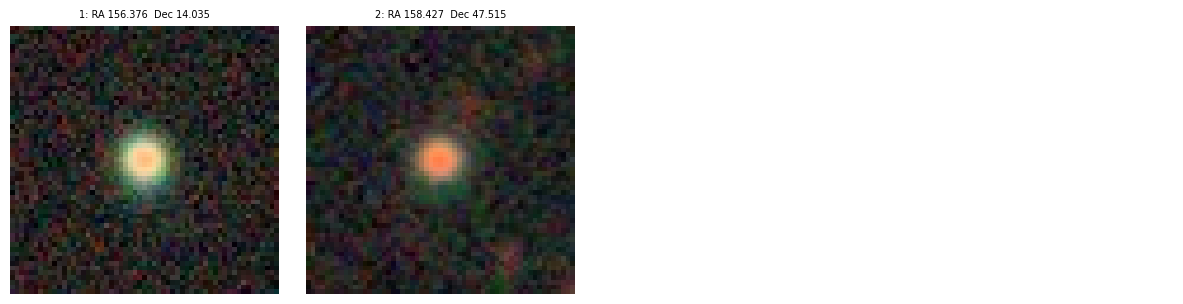

In [33]:
# ================================================================
# DECaLS cut-outs for LRD candidates  –  download + gallery
# ================================================================
import os, math, io, requests, numpy as np
from datetime import datetime
from PIL import Image, ImageDraw, UnidentifiedImageError
import matplotlib.pyplot as plt

# ----------------------------------------------------------------
# 0.  Setup
# ----------------------------------------------------------------
fov_arcsec = 15.0           # full side length of the stamp   ← EDIT HERE
pixscale   = 0.262          # native DECaLS (arcsec / pix)
size_pix   = max(16, int(round(fov_arcsec / pixscale)))   # ensure ≥16 px
layer      = 'ls-dr9'
bands      = 'grz'
timeout    = 10             # HTTP timeout (s)

download_folder = os.path.expanduser("~/data/decals_lrd_jpg/")
os.makedirs(download_folder, exist_ok=True)

# ----------------------------------------------------------------
# 1.  Candidate table  (df_use & lrd_can from previous cell)
# ----------------------------------------------------------------
df_cand = df_use[lrd_can].reset_index(drop=True)
ncand   = len(df_cand)
if ncand == 0:
    raise RuntimeError("No candidates to fetch!")

print(f"{datetime.utcnow():%Y-%m-%d %H:%M:%S}  "
      f"Fetching {ncand} DECaLS cut-outs  ({fov_arcsec}″ FoV, {size_pix}×{size_pix} px)…")

# ----------------------------------------------------------------
# 2.  Download loop  (JPEG)
# ----------------------------------------------------------------
base_url = "https://www.legacysurvey.org/viewer/cutout.jpg"
images   = []          # keep PIL images in memory for gallery

for idx, row in df_cand.iterrows():
    ra_cur, dec_cur = row['decals_ra'], row['decals_dec']
    params = {
        'ra'      : f"{ra_cur:.6f}",
        'dec'     : f"{dec_cur:.6f}",
        'layer'   : layer,
        'pixscale': pixscale,
        'size'    : size_pix,
        'bands'   : bands,
    }
    url = requests.Request('GET', base_url, params=params).prepare().url

    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        if 'image' not in r.headers.get('content-type',''):
            raise UnidentifiedImageError("Non-image response")
        img = Image.open(io.BytesIO(r.content)).convert('RGB')
    except Exception as e:
        # create a placeholder tile
        img = Image.new('RGB', (size_pix, size_pix), color='black')
        draw = ImageDraw.Draw(img)
        draw.text((4, size_pix//2 - 6), "ERR", fill="white")
        print(f"[{idx+1}/{ncand}] FAILED  RA={ra_cur:.3f}  Dec={dec_cur:.3f} : {e}")

    # save to disk
    fname = f"lrdcand_{idx:04d}_RA{ra_cur:.4f}_Dec{dec_cur:.4f}.jpg"
    fpath = os.path.join(download_folder, fname)
    img.save(fpath, quality=92)
    images.append(img)

    print(f"[{idx+1}/{ncand}] saved → {fname}")

# ----------------------------------------------------------------
# 3.  Gallery (4 per row)
# ----------------------------------------------------------------
ncols, nrows = 4, math.ceil(len(images)/4)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))

for i, img in enumerate(images):
    ax = axes.flat[i] if nrows > 1 else axes[i]
    ax.imshow(img)
    ra, dec = df_cand.loc[i, ['decals_ra','decals_dec']]
    ax.set_title(f"{i+1}: RA {ra:.3f}  Dec {dec:.3f}", fontsize=7)
    ax.axis('off')

# hide any empty panels
for j in range(len(images), nrows*ncols):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(download_folder, "lrd_candidates_gallery.png"), dpi=150, bbox_inches='tight')
plt.show()